## Basic Models

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib as plt
import seaborn as sns

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

meta = pd.read_csv("META.csv")
meta = meta[2:]
meta = meta.reset_index()
meta = meta.drop(columns=["index"])
# Rename 'Date' column in meta to 'Price', the original column name in the CSV.
meta = meta.rename(columns={"Price":"Date"})
columns_to_convert = ["Close", "High", "Low", "Open"]
meta.head()

meta[columns_to_convert] = meta[columns_to_convert].astype(float)
meta['Date'] = pd.to_datetime(meta['Date']) # Convert the 'Date' column to datetime
meta['Volume'] = meta['Volume'].astype(int)
# meta.head() # Uncomment to check the DataFrame structure

df = meta
# Now you can filter using the 'Date' column:
df = df[df['Date']>=pd.Timestamp(2020,1,1)].reset_index().drop(columns=["index"]) # Use pd.Timestamp
df = df[df['Date']<pd.Timestamp(2025,1,31)] # Use pd.Timestamp

In [3]:
# 1. Basic Information
print("\nDataset Information:\n")
print(df.info())

# 2. Summary Statistics
print("\nSummary Statistics:\n")
print(df.describe())

# 3. Checking for Missing Values
print("\nMissing Values:\n")
print(df.isnull().sum())


Dataset Information:

<class 'pandas.core.frame.DataFrame'>
Index: 1277 entries, 0 to 1276
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1277 non-null   datetime64[ns]
 1   Close   1277 non-null   float64       
 2   High    1277 non-null   float64       
 3   Low     1277 non-null   float64       
 4   Open    1277 non-null   float64       
 5   Volume  1277 non-null   int32         
dtypes: datetime64[ns](1), float64(4), int32(1)
memory usage: 64.8 KB
None

Summary Statistics:

                                Date        Close         High          Low  \
count                           1277  1277.000000  1277.000000  1277.000000   
mean   2022-07-15 11:43:38.950665728   305.080171   309.187244   300.787705   
min              2020-01-02 00:00:00    88.492935    90.035660    87.676766   
25%              2021-04-09 00:00:00   209.194061   211.732110   205.979214   
50%              2022-07-15 00:0

### Linear Classifier

Precision Score for Logistic Regression: 0.55


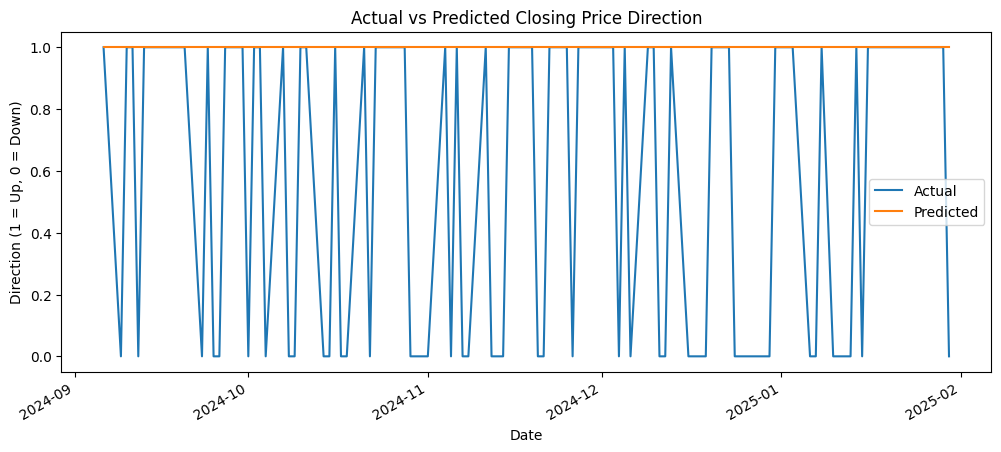

In [4]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt

# Assume df has columns: Date, Close, High, Low, Open, Volume

# Set Date as index
df = df.set_index('Date')

# Create binary target: 1 if Close price goes up next day, else 0
df["Target"] = (df["Close"].shift(-1) > df["Close"]).astype(int)

# Drop the last row with NaN from shift
df = df.dropna()

# Define predictors and target
predictors = ["Volume", "Open", "High", "Low"]
target = "Target"

# Train-test split
train = df.iloc[:-100]
test = df.iloc[-100:]

# Initialize and train Logistic Regression model
model = LogisticRegression(random_state=1, max_iter=1000)
model.fit(train[predictors], train[target])

# Make predictions
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)

# Evaluate performance
precision = precision_score(test[target], preds)
print("Precision Score for Logistic Regression:", precision)

# Combine and plot actual vs predicted
combined = pd.concat([test[target], preds], axis=1)
combined.columns = ["Actual", "Predicted"]
combined.plot(title="Actual vs Predicted Closing Price Direction", figsize=(12, 5))
plt.ylabel("Direction (1 = Up, 0 = Down)")
plt.show()


In [5]:
print(df["Target"].value_counts(normalize=True))

Target
1    0.522318
0    0.477682
Name: proportion, dtype: float64


Precision: 0.6470588235294118
Accuracy: 0.55
Confusion Matrix:
 [[33 12]
 [33 22]]
Unique Predictions: [0 1]


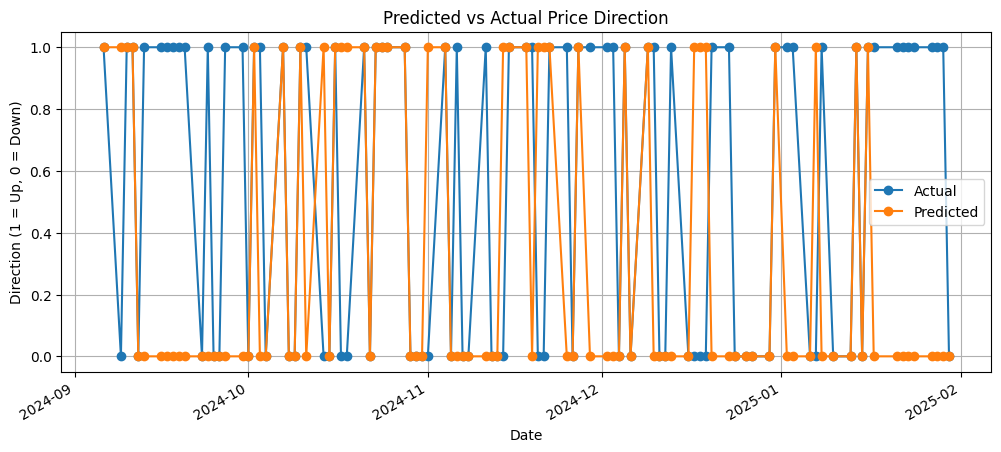

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, accuracy_score, confusion_matrix

# Preprocessing
# df = df.set_index('Date')

# Create binary target: 1 if price increases next day
df["Target"] = (df["Close"].shift(-1) > df["Close"]).astype(int)
df = df.dropna()

# Optional: Create new features
df["Price_Change"] = df["Close"] - df["Open"]
df["MA_3"] = df["Close"].rolling(3).mean()
df["MA_7"] = df["Close"].rolling(7).mean()
df["MA_Crossover"] = (df["MA_3"] > df["MA_7"]).astype(int)
df = df.dropna()

# Define predictors (include engineered features)
predictors = ["Volume", "Open", "High", "Low", "Price_Change", "MA_Crossover"]

# Split data
train = df.iloc[:-100]
test = df.iloc[-100:]

# Scale features
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[predictors])
test_scaled = scaler.transform(test[predictors])

# Train model
model = LogisticRegression(random_state=1, max_iter=1000)
model.fit(train_scaled, train["Target"])

# Predict
preds = model.predict(test_scaled)
preds_series = pd.Series(preds, index=test.index)

# Evaluation
print("Precision:", precision_score(test["Target"], preds))
print("Accuracy:", accuracy_score(test["Target"], preds))
print("Confusion Matrix:\n", confusion_matrix(test["Target"], preds))
print("Unique Predictions:", np.unique(preds))

# Plot predictions vs actual
combined = pd.DataFrame({"Actual": test["Target"], "Predicted": preds}, index=test.index)
combined.plot(title="Predicted vs Actual Price Direction", figsize=(12, 5), marker='o')
plt.ylabel("Direction (1 = Up, 0 = Down)")
plt.grid(True)
plt.show()

### Random Forest

In [7]:
meta["Target"] = (meta["Close"].shift(-1) > meta["Close"]).astype(int)

In [8]:
meta.dropna(inplace=True)

In [9]:
meta["Date"] = pd.to_datetime(meta["Date"])
meta.set_index("Date", inplace=True)

Precision Score for Random Forest: 0.6153846153846154


<Axes: xlabel='Date'>

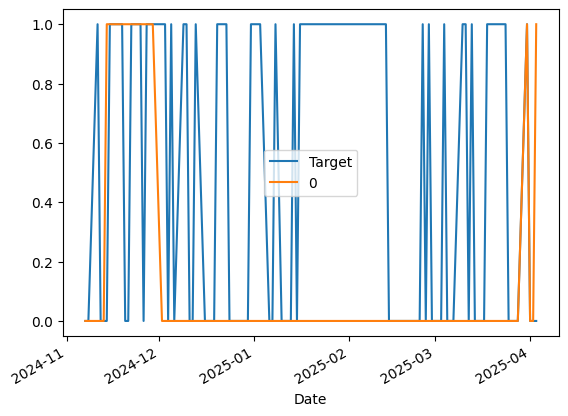

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = meta.iloc[:-100]
test = meta.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision = precision_score(test["Target"], preds)
print("Precision Score for Random Forest:", precision)

combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()